## Tutorial 3: Creating a *scenario* from data

In this tutorial, we will cover the following items:



In [1]:
# Before starting, let us do the necessary imports
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from domain_model import Activity, ActivityCategory, Actor, ActorCategory, \
    Constant, Linear, PhysicalElement, PhysicalElementCategory, Scenario, Sinusoidal, \
    StateVariable, Spline3Knots, Splines, Tag, VehicleType

## 1. The data that is used to create the *scenario*

In this tutorial, we will create a *scenario* in which another vehicle changes lane such that it becomes the ego vehicle's leading vehicle. We have already seen this in [tutorial 1](./Tutorial%201%20Scenario%20category.ipynb) and [tutorial 2](./Tutorial%202%20Scenario.ipynb), where we created a *scenario category* and *scenario*, respectively. In this tutorial, however, we will demonstrate how a scenario can be created by using original data. The most important aspect of this tutorial is to see how the parameters of the *activities* can be fitted to the data.

The *scenario* is depicted in the figure below. Here, the blue car represents the ego vehicle and the red car represents the vehicle that performs the cut in.

<img src="./examples/images/cut-in.png" alt="Cut in" width="400"/>

In [2]:
# Load the data.
DF = pd.read_csv(os.path.join("examples", "data_cutin_scenario.csv"), index_col=0)
DF.head()

,v_ego,line_left,line_right,d_target,v_target,act_lon_ego,act_lat_ego,line_left_target,line_right_target,act_lon_target,act_lat_target
0.00,28.428819,1.418947,-0.726599,71.759022,21.763572,c,fl,5.027697,2.882150,c,fl
0.01,28.417771,1.345163,-0.747960,71.664646,21.799396,c,fl,5.029092,2.935968,c,fl
0.02,28.366639,1.367334,-0.874371,71.593028,21.769714,c,fl,5.054492,2.812787,c,fl
0.03,28.350828,1.347444,-0.786704,71.441175,21.729920,c,fl,5.056625,2.922477,c,fl
0.04,28.412578,1.374992,-0.703872,71.454351,21.704001,c,fl,5.093037,3.014173,c,fl


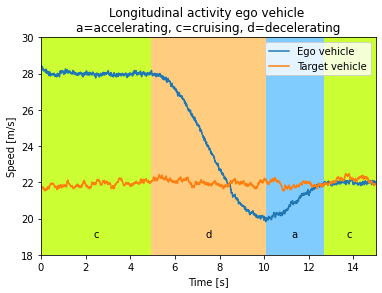

In [3]:
# Plot the speed of both the ego vehicle and the target vehicle
plt.plot(DF["v_ego"], label="Ego vehicle")
plt.plot(DF["v_target"], label="Target vehicle")
plt.xlabel("Time [s]")
plt.ylabel("Speed [m/s]")
plt.legend(loc="upper right")
XLIM = plt.xlim(0, DF.index[-1])
YLIM = plt.ylim(18, 30)

# Color the background to show the longitudinal activity of the ego vehicle.
I_EVENT_LON_EGO = DF.index[DF["act_lon_ego"] != DF["act_lon_ego"].shift()].to_list()
I_EVENT_LON_EGO.append(DF.index[-1])
COLORS = dict(a=(.5, .8, 1), c=(.8, 1, .2), d=(1, .8, .5))
for i_start, i_end in zip(I_EVENT_LON_EGO[:-1], I_EVENT_LON_EGO[1:]):
    plt.fill([i_start, i_end, i_end, i_start], [YLIM[0], YLIM[0], YLIM[1], YLIM[1]], 
             color=COLORS[DF.at[i_start, "act_lon_ego"]])
    plt.text((i_start+i_end)/2, 19, DF.at[i_start, "act_lon_ego"], horizontalAlignment="center")
plt.title("Longitudinal activity ego vehicle \na=accelerating, c=cruising, d=decelerating")
plt.show()

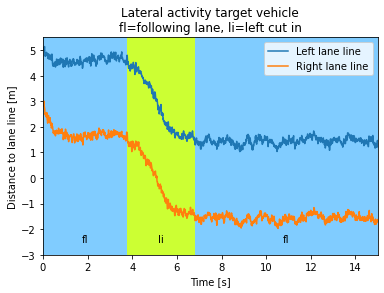

In [4]:
# Plot the distance of the target to the ego vehicles lane lines.
plt.plot(DF["line_left_target"], label="Left lane line")
plt.plot(DF["line_right_target"], label="Right lane line")
plt.xlabel("Time [s]")
plt.ylabel("Distance to lane line [m]")
plt.legend(loc="upper right")
XLIM = plt.xlim(0, DF.index[-1])
YLIM = plt.ylim(-3, 5.5)

# Color the background to show the lateral activity of the target vehicle.
I_EVENT_LAT_TARGET = DF.index[DF["act_lat_target"] != DF["act_lat_target"].shift()].to_list()
I_EVENT_LAT_TARGET.append(DF.index[-1])
COLORS = dict(fl=(.5, .8, 1), li=(.8, 1, .2))
for i_start, i_end in zip(I_EVENT_LAT_TARGET[:-1], I_EVENT_LAT_TARGET[1:]):
    plt.fill([i_start, i_end, i_end, i_start], [YLIM[0], YLIM[0], YLIM[1], YLIM[1]], 
             color=COLORS[DF.at[i_start, "act_lat_target"]])
    plt.text((i_start+i_end)/2, -2.5, DF.at[i_start, "act_lat_target"], horizontalAlignment="center")
plt.title("Lateral activity target vehicle\nfl=following lane, li=left cut in")
plt.show()

## 2

In [5]:
# First create the activity categories
CRUISING_CATEGORY = ActivityCategory(
    Constant(), StateVariable.SPEED, name="Cruising",
    description="Cruising at a constant positive speed",
    tags=[Tag.VehicleLongitudinalActivity_DrivingForward_Cruising])
BRAKING_CATEGORY = ActivityCategory(
    Sinusoidal(), StateVariable.SPEED, name="Braking",
    description="Decelerating to a lower speed",
    tags=[Tag.VehicleLongitudinalActivity_DrivingForward_Braking])
ACCELERATING_CATEGORY = ActivityCategory(
    Splines(n_knots=1), StateVariable.SPEED, name="Acccelerating",
    description="Accelerating to a higher speed",
    tags=[Tag.VehicleLongitudinalActivity_DrivingForward_Accelerating])
FOLLOWING_LANE_CATEGORY = ActivityCategory(
    Linear(), StateVariable.LATERAL_POSITION, name="Following lane",
    description="Stay in one lane",
    tags=[Tag.VehicleLateralActivity_GoingStraight])
CHANGING_LANE_CATEGORY = ActivityCategory(
    Spline3Knots(), StateVariable.LATERAL_POSITION, name="Changing lane",
    description="Change one lane to the left or to the right",
    tags=[Tag.VehicleLateralActivity_ChangingLane])

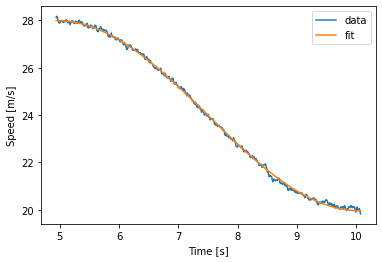

In [6]:
# Fit the braking activity of the ego vehicle.
TIME = DF.loc[I_EVENT_LON_EGO[1]:I_EVENT_LON_EGO[2]].index.to_list()
PARAMETERS = BRAKING_CATEGORY.fit(TIME, DF.loc[I_EVENT_LON_EGO[1]:I_EVENT_LON_EGO[2], "v_ego"])

# Create the braking activity.
BRAKING_EGO = Activity(BRAKING_CATEGORY, PARAMETERS, start=I_EVENT_LON_EGO[1], 
                       end=I_EVENT_LON_EGO[2], name="Braking ego")

# Show the resulting fit.
plt.plot(DF.loc[I_EVENT_LON_EGO[1]:I_EVENT_LON_EGO[2], "v_ego"], label="data")
plt.plot(TIME, BRAKING_EGO.get_state(PARAMETERS, time=np.array(TIME)), label="fit")
plt.xlabel("Time [s]")
plt.ylabel("Speed [m/s]")
plt.legend()
plt.show()

In [7]:
# Fit the other longitudinal activities of the ego vehicle.
TIME = DF.loc[:I_EVENT_LON_EGO[1]].index.to_list()
PARAMETERS = CRUISING_CATEGORY.fit(TIME, DF.loc[:I_EVENT_LON_EGO[1], "v_ego"])
CRUISING_EGO1 = Activity(CRUISING_CATEGORY, PARAMETERS, start=I_EVENT_LON_EGO[0],
                         end=BRAKING_EGO.start, name="Initial cruising ego")
TIME = DF.loc[I_EVENT_LON_EGO[2]:I_EVENT_LON_EGO[3]].index.to_list()
PARAMETERS = ACCELERATING_CATEGORY.fit(TIME, DF.loc[I_EVENT_LON_EGO[2]:I_EVENT_LON_EGO[3], "v_ego"])
ACCELERATING_EGO = Activity(ACCELERATING_CATEGORY, PARAMETERS, start=BRAKING_EGO.end, 
                            end=I_EVENT_LON_EGO[3], name="Initial cruising ego")
TIME = DF.loc[I_EVENT_LON_EGO[3]:].index.to_list()
PARAMETERS = CRUISING_CATEGORY.fit(TIME, DF.loc[I_EVENT_LON_EGO[3]:, "v_ego"])
CRUISING_EGO2 = Activity(CRUISING_CATEGORY, PARAMETERS, start=ACCELERATING_EGO.end,
                         end=I_EVENT_LON_EGO[4], name="Final cruising ego")

In [8]:
# Create the activity that describes the lateral movement of the ego vehicle.
Y_CENTER = DF["line_left"] - DF["line_right"]
PARAMETERS = FOLLOWING_LANE_CATEGORY.fit(np.array(DF.index), -DF["line_right"].values)
STRAIGHT_EGO = Activity(FOLLOWING_LANE_CATEGORY, PARAMETERS,
                        start=CRUISING_EGO1.start, end=CRUISING_EGO2.end, name="Following lane ego")

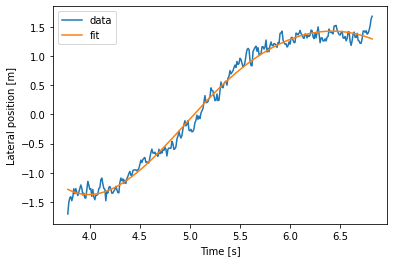

In [9]:
# Create activity that describes the lane change of the target vehicle.
Y_TARGET = 1.5 - (DF["line_left_target"] + DF["line_right_target"])/2
TIME = np.array(DF.loc[I_EVENT_LAT_TARGET[1]:I_EVENT_LAT_TARGET[2]].index.to_list())
PARAMETERS = CHANGING_LANE_CATEGORY.fit(TIME, Y_TARGET[I_EVENT_LAT_TARGET[1]:I_EVENT_LAT_TARGET[2]])
LANE_CHANGE_TARGET = Activity(CHANGING_LANE_CATEGORY, PARAMETERS, start=I_EVENT_LAT_TARGET[1],
                              end=I_EVENT_LAT_TARGET[2], name="Lane change target",
                              tags=[Tag.VehicleLateralActivity_ChangingLane_Left])

# Show the resulting fit.
plt.plot(Y_TARGET[I_EVENT_LAT_TARGET[1]:I_EVENT_LAT_TARGET[2]], label="data")
plt.plot(TIME, LANE_CHANGE_TARGET.get_state(PARAMETERS, time=TIME), label="fit")
plt.xlabel("Time [s]")
plt.ylabel("Lateral position [m]")
plt.legend()
plt.show()

In [10]:
# Fit the other lateral activities of the target vehicle.
TIME = DF.loc[I_EVENT_LAT_TARGET[0]:I_EVENT_LAT_TARGET[1]].index.to_list()
PARAMETERS = FOLLOWING_LANE_CATEGORY.fit(TIME, Y_TARGET[:I_EVENT_LAT_TARGET[1]])
STRAIGHT_TARGET1 = Activity(FOLLOWING_LANE_CATEGORY, PARAMETERS,
                            start=CRUISING_EGO1.start, end=LANE_CHANGE_TARGET.start)
TIME = DF.loc[I_EVENT_LAT_TARGET[2]:I_EVENT_LAT_TARGET[3]].index.to_list()
PARAMETERS = FOLLOWING_LANE_CATEGORY.fit(TIME, Y_TARGET[I_EVENT_LAT_TARGET[2]:])
STRAIGHT_TARGET2 = Activity(FOLLOWING_LANE_CATEGORY, PARAMETERS,
                            start=LANE_CHANGE_TARGET.end, end=CRUISING_EGO2.end)

In [11]:
# Finally, fit the longitudinal activity of the target vehicle.
PARAMETERS = CRUISING_CATEGORY.fit(np.array(DF.index), DF["v_target"].values)
CRUISING_TARGET = Activity(CRUISING_CATEGORY, PARAMETERS,
                           start=CRUISING_EGO1.start, end=CRUISING_EGO2.end)

## 3

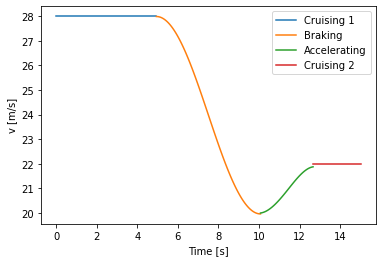

In [12]:
axes = CRUISING_EGO1.plot(label="Cruising 1")
BRAKING_EGO.plot(axes, label="Braking")
ACCELERATING_EGO.plot(axes, label="Accelerating")
CRUISING_EGO2.plot(axes, label="Cruising 2")
plt.legend()
plt.show()

## 4

In [13]:
BRAKING_EGO.get_state(time=8)

array([22.77539055])

In [14]:
BRAKING_EGO.get_state(time=[6, 7, 8, 9])

array([27.17332744, 25.19647827, 22.77539055, 20.79001855])

In [15]:
BRAKING_EGO.get_state(time=np.linspace(BRAKING_EGO.get_tstart(),
                                       BRAKING_EGO.get_tend(), 10))

array([27.99015477, 27.74796364, 27.05060209, 25.98218221, 24.6715712 ,
       23.27684809, 21.96623708, 20.8978172 , 20.20045565, 19.95826452])

## 5

In [16]:
# Create the actor categories.
EGO_VEHICLE_QUALITATIVE = ActorCategory(VehicleType.Vehicle, name="Ego vehicle", 
                                        tags=[Tag.EgoVehicle, Tag.RoadUserType_Vehicle])
TARGET_VEHICLE_QUALITATIVE = ActorCategory(VehicleType.Vehicle, name="Target vehicle",
                                           tags=[Tag.RoadUserType_Vehicle])

In [17]:
# Create the actors.
EGO_VEHICLE = Actor(EGO_VEHICLE_QUALITATIVE,
                    properties=dict(color="blue"),
                    name="ego vehicle")
TARGET_VEHICLE = Actor(TARGET_VEHICLE_QUALITATIVE,
                       properties=dict(color="red"),
                       name="target vehicle")

In [18]:
# Create the scenario.
CUTIN = Scenario(start=CRUISING_EGO1.start, end=CRUISING_EGO2.end, name="cut-in scenario")
CUTIN.set_actors([EGO_VEHICLE, TARGET_VEHICLE])
CUTIN.set_activities([CRUISING_EGO1, BRAKING_EGO, ACCELERATING_EGO, CRUISING_EGO2,
                      STRAIGHT_EGO, CRUISING_TARGET, 
                      STRAIGHT_TARGET1, LANE_CHANGE_TARGET, STRAIGHT_TARGET2])
CUTIN.set_acts([(EGO_VEHICLE, CRUISING_EGO1),
                (EGO_VEHICLE, BRAKING_EGO),
                (EGO_VEHICLE, ACCELERATING_EGO),
                (EGO_VEHICLE, CRUISING_EGO2),
                (EGO_VEHICLE, STRAIGHT_EGO),
                (TARGET_VEHICLE, CRUISING_TARGET),
                (TARGET_VEHICLE, STRAIGHT_TARGET1),
                (TARGET_VEHICLE, LANE_CHANGE_TARGET),
                (TARGET_VEHICLE, STRAIGHT_TARGET2)])

In [19]:
def error_ego_speed(parameters):
    """ Return the RMSE of the ego speed.
    
    :param parameters: The six parameters that define the ego speed.
    :return: The resulting RMSE.
    """
    CRUISING_EGO1.parameters['xstart'] = parameters[0]
    BRAKING_EGO.parameters['xstart'] = parameters[0]
    BRAKING_EGO.parameters['xend'] = parameters[1]
    ACCELERATING_EGO.parameters['coefficients'][0:2] = parameters[1]
    ACCELERATING_EGO.parameters['coefficients'][2] = parameters[2]
    ACCELERATING_EGO.parameters['coefficients'][3:5] = parameters[3]
    CRUISING_EGO2.parameters['xstart'] = parameters[3]
    speed = CUTIN.get_state(EGO_VEHICLE, StateVariable.SPEED, DF.index.to_list())
    return np.sqrt(np.sum((speed - DF["v_ego"].values)**2) / len(DF["v_ego"]))

In [20]:
XINIT = [CRUISING_EGO1.parameters['xstart'], 
         BRAKING_EGO.parameters['xend'],
         ACCELERATING_EGO.parameters['coefficients'][2],
         CRUISING_EGO2.parameters['xstart']]

In [21]:
result = minimize(error_ego_speed, XINIT)
print(result.x)
print("Residual error: {:.3f}".format(error_ego_speed(result.x)))

[27.99600578 19.97527475 20.78986192 21.95723262]
Residual error: 0.090


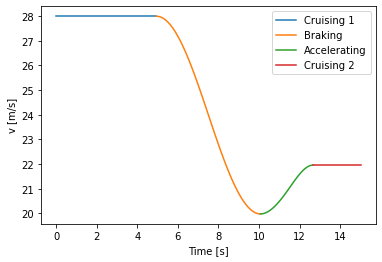

In [22]:
axes = CRUISING_EGO1.plot(label="Cruising 1")
BRAKING_EGO.plot(axes, label="Braking")
ACCELERATING_EGO.plot(axes, label="Accelerating")
CRUISING_EGO2.plot(axes, label="Cruising 2")
plt.legend()
plt.show()